## IN3050/IN4050 Mandatory Assignment 2, 2022: Supervised Learning

Andrew Quan (asquan)

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html , in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 25, 2022, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [1169]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

# Part 1: Linear classifiers
## Datasets
We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [1170]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,400,400, 400, 400], centers=[[0,1],[4,1],[8,1],[2,0],[6,0]], 
                  n_features=2, random_state=2019, cluster_std=1.0)

In [1171]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [1172]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_train = t[indices[:1000]]
t_val = t[indices[1000:1500]]
t_test = t[indices[1500:]]


Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [1173]:
t2_train = t_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_val >= 3).astype('int')
t2_test = (t_test >= 3).astype('int')

We can plot the two traing sets.

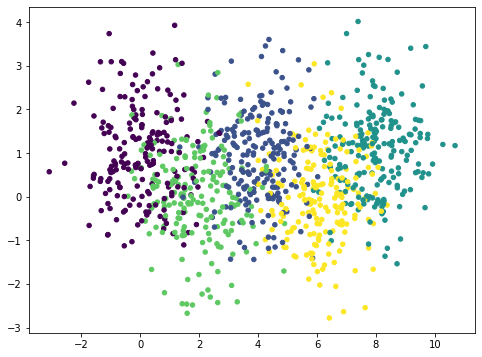

In [1174]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train, s=20.0)
plt.show()

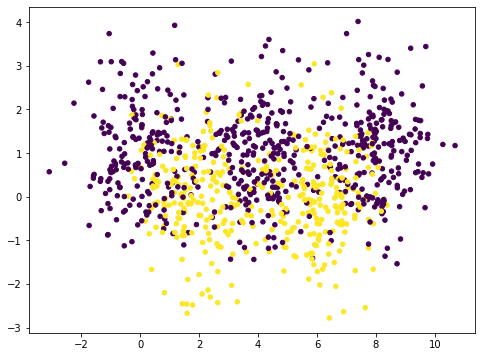

In [1175]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=20.0)
plt.show()

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7, which we include here.

In [1176]:
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1) 

In [1177]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

    def accuracy2(self,X_test, y_test, **kwargs):
        pred = self.predict2(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

In [1178]:
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, loss_diff=1e-10, validation_set=None):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        
        self.weights = weights = np.zeros(m+1)
        #X_train = add_bias(X_train)
        if validation_set:
            X_val, t_val = validation_set
            
        X_train = add_bias(X_train)
        
        #X_val = add_bias(X_val) #Skal X_val ha bias?
        self.losses = []
        self.val_accs = []
        self.train_accs = []
        for e in range(epochs):
            prev_loss = self.losses[-1] if self.losses else float('inf')
            
            if validation_set:
                loss = (np.sum((t_val - (self.predict3(X_val)))**2))/len(t_val)

            else:
                loss = (np.sum((t_train - X_train@weights)**2))/len(t_train)
            #self.losses.append(loss)
            
            if np.abs(loss - prev_loss) <= loss_diff:
                self.epoch = e
                break
            
            
            self.losses.append(loss)
            if validation_set:
                self.train_accs.append(self.accuracy2(X_train, t_train))
                self.val_accs.append(self.accuracy(X_val, t_val))
            weights -= eta / k * X_train.T @ (X_train @ weights - t_train)
            

                



    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score>threshold

    def predict2(self, x, threshold=0.5):
        score = x @ self.weights
        return score>threshold
    
    def predict3(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score



We can train and test a first classifier.

In [1179]:
def parameters_experiment():
	best_acc = 0
	cl = NumpyLinRegClass()
	for eta in [0.1, 0.01, 0.001, 0.0001]:
		for epochs in [10, 100, 1000, 10000]:
			cl.fit(X_train, t2_train, eta=eta, epochs=epochs)
			acc = cl.accuracy(X_val, t2_val)
			if acc > best_acc:
				best_acc = acc
				best_epochs = epochs
				best_eta = eta
			print(f"Learning rate: {eta}  Epochs: {epochs:7}  Accuracy: {acc}")
	return best_eta, best_epochs, best_acc

lin_r_best_eta, lin_r_best_epochs, lin_r_best_acc = parameters_experiment()
print("best parameters for best accuracy:")
print(f"Learning rate: {lin_r_best_eta}  Epochs: {lin_r_best_epochs:7}  Accuracy: {lin_r_best_acc}")



Learning rate: 0.1  Epochs:      10  Accuracy: 0.49
Learning rate: 0.1  Epochs:     100  Accuracy: 0.484
Learning rate: 0.1  Epochs:    1000  Accuracy: 0.484


/usr/local/anaconda3/envs/in3050/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/sl/wrhq9yzx317b0c3t_xkgr2y40000gn/T/ipykernel_63127/3923059652.py:30: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(loss - prev_loss) <= loss_diff:
/var/folders/sl/wrhq9yzx317b0c3t_xkgr2y40000gn/T/ipykernel_63127/3923059652.py:27: RuntimeWarning: overflow encountered in square
  loss = (np.sum((t_train - X_train@weights)**2))/len(t_train)
/var/folders/sl/wrhq9yzx317b0c3t_xkgr2y40000gn/T/ipykernel_63127/3923059652.py:27: RuntimeWarning: overflow encountered in matmul
  loss = (np.sum((t_train - X_train@weights)**2))/len(t_train)
/var/folders/sl/wrhq9yzx317b0c3t_xkgr2y40000gn/T/ipykernel_63127/3923059652.py:39: RuntimeWarning: overflow encountered in matmul
  weights -= eta / k * X_train.T @ (X_train @ weights - t_train)
/var/folders/sl/wrhq9yzx317b0c3t_x

Learning rate: 0.1  Epochs:   10000  Accuracy: 0.572
Learning rate: 0.01  Epochs:      10  Accuracy: 0.54
Learning rate: 0.01  Epochs:     100  Accuracy: 0.552
Learning rate: 0.01  Epochs:    1000  Accuracy: 0.656
Learning rate: 0.01  Epochs:   10000  Accuracy: 0.668
Learning rate: 0.001  Epochs:      10  Accuracy: 0.572
Learning rate: 0.001  Epochs:     100  Accuracy: 0.552
Learning rate: 0.001  Epochs:    1000  Accuracy: 0.552
Learning rate: 0.001  Epochs:   10000  Accuracy: 0.656
Learning rate: 0.0001  Epochs:      10  Accuracy: 0.572
Learning rate: 0.0001  Epochs:     100  Accuracy: 0.572
Learning rate: 0.0001  Epochs:    1000  Accuracy: 0.552
Learning rate: 0.0001  Epochs:   10000  Accuracy: 0.552
best parameters for best accuracy:
Learning rate: 0.01  Epochs:   10000  Accuracy: 0.668


The result is far from impressive. Experiment with various settings for the hyper-parameters, eta and epochs. Report how the accuracy vary with the hyper-parameter settings. When you are satisfied with the result, you may plot the decision boundaries, as below.

Feel free to improve the colors and the rest av of the graphics. We have chosen a simple set-up which can be applied to more than two classes without substanial modifications.

In [1180]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=20.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

plt.show()

0.668


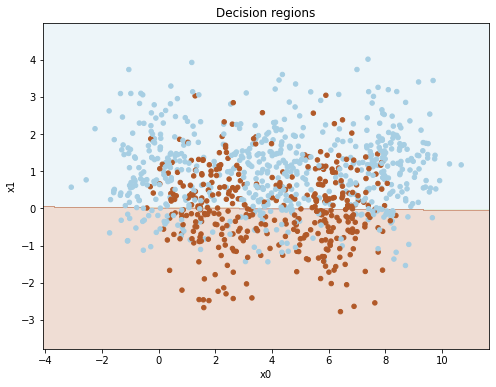

In [1181]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, eta=best_eta, epochs=best_epochs)
print(cl.accuracy(X_val, t2_val))
plot_decision_regions(X_train, t2_train, cl)

### Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs.

Final loss: 0.1930258039416
number of epochs before stopping: 2536


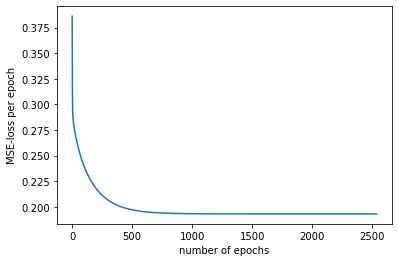

In [1182]:
def plot_loss():
    cl.fit(X_train, t2_train, eta=best_eta, epochs=best_epochs)
    plt.plot(np.linspace(0, cl.epoch, cl.epoch), cl.losses)
    plt.xlabel("number of epochs")
    plt.ylabel("MSE-loss per epoch")
    print("Final loss:", cl.losses[-1])
    print("number of epochs before stopping:", cl.epoch)
plot_loss()
plt.show()
    

### Control training
The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with a keyword argument, `loss_diff`, and stop training when the loss has not improved with more than loss_diff. Also add an attribute to the classifier which tells us after fitting how many epochs were ran.

In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss for the validation set, and the accuracy for both the training set and the validation set for each epoch.

Train classifiers with the best value for learning rate so far, and with varying values for `loss_diff`. For each run report, `loss_diff`, accuracy and number of epochs ran.

After a succesful training, plot both training loss snd vslidation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [1183]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, eta = best_eta, epochs = best_epochs, loss_diff = 1e-8)
print(cl.epoch)



1780


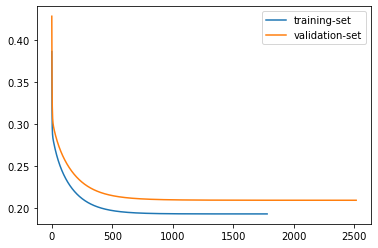

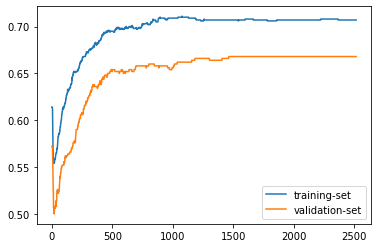

In [1184]:
def loss_diff_report():
    cl = NumpyLinRegClass()
    diffs= [1e-3, 1e-2, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
    for diff in diffs:
        cl.fit(X_train, t2_train, eta = best_eta, epochs = best_epochs, loss_diff = diff)
        print(f"Loss difference: {diff}  Accuracy: {cl.accuracy(X_val, t2_val)}  Epochs before stopping: {cl.epoch}")

def plot_losses():
    cl_training = NumpyLinRegClass()
    cl_validation = NumpyLinRegClass()

    cl_training.fit(X_train, t2_train, eta = best_eta, epochs = best_epochs, loss_diff = 1e-8)
    cl_validation.fit(X_train, t2_train, eta = best_eta, epochs = best_epochs, loss_diff = 1e-8, validation_set = (X_val, t2_val))
    plt.figure(1)
    plt.plot(np.linspace(0, cl_training.epoch, cl_training.epoch), cl_training.losses, label = "training-set")
    plt.plot(np.linspace(0, cl_validation.epoch, cl_validation.epoch), cl_validation.losses, label = "validation-set")
    plt.legend()
    plt.figure(2)
    plt.plot(np.linspace(0, cl_validation.epoch, cl_validation.epoch), cl_validation.train_accs, label = "training-set")
    plt.plot(np.linspace(0, cl_validation.epoch, cl_validation.epoch), cl_validation.val_accs, label = "validation-set")
    plt.legend()
plot_losses()

plt.show()

### Logistic regression
You should now do similarly for a logistic regression classifier. Calculate loss and accuracy for training set and, when provided, also for validation set.

Remember that logistic regression is trained with cross-entropy loss. Hence the loss function is calculated differently than for linear regression.

After a succesful training, plot both losses as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. 

Comment on what you see. Do you see any differences between the linear regression classifier and the logistic regression classifier on this dataset?

#### Starting point: Code from weekly 7

In [1185]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [1186]:
class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, loss_diff = 1e-5, validation_set = None):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        if validation_set:
            X_val, t2_val = validation_set
            X_val = add_bias(X_val)
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        
        self.t_loss = []
        self.val_loss = []
        self.t_accuracy = []
        self.val_accuracy = []
        for e in range(epochs):
            if validation_set:
                val_y = self.forward(X_val)
                val_loss = np.sum(-np.log((val_y**t2_val) * (1-val_y)**(1-t2_val)))
                self.val_loss.append(val_loss)
                
            t_y = self.forward(X_train)
            t_loss = np.sum(-np.log((t_y**t_train) * (1-t_y)**(1-t_train)))
            self.t_loss.append(t_loss)

            weights -= eta / k *  X_train.T @ (self.forward(X_train) - t_train)  
            self.epoch = e
            
            if validation_set:
                self.val_accuracy.append(self.accuracy2(X_val, t2_val))
                
            self.t_accuracy.append(self.accuracy2(X_train, t2_train))
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')
    
    def predict2(self, x, threshold=0.5):
        score = self.forward(x)
        return (score>threshold).astype('int')


In [1187]:
def experiment_hyperparamter():
    best_acc = 0
    cl = NumpyLogReg()
    for eta in [0.1, 0.01, 0.001]:
        for epochs in [10, 100, 1000, 10000]:
            cl.fit(X_train, t2_train, eta = eta, epochs = epochs)
            cl.predict(X_val)
            acc = cl.accuracy(X_val, t_val)
            if acc > best_acc:
                best_acc = acc 
                best_eta = eta
                best_epochs = epochs
    return best_acc, best_eta, best_epochs

log_r_best_acc, log_r_best_eta, log_r_best_epochs = experiment_hyperparamter()
print(log_r_best_acc, log_r_best_eta, log_r_best_epochs)
        

0.188 0.1 1000


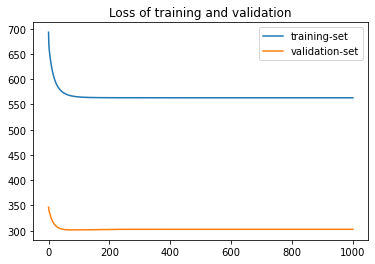

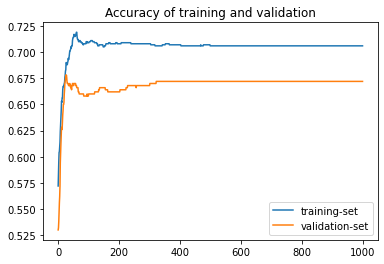

In [1188]:
cl = NumpyLogReg()
epochs = log_r_best_epochs
cl.fit(X_train, t2_train, eta=log_r_best_eta, epochs = epochs, validation_set= (X_val, t2_val))
x = np.linspace(0, epochs, epochs)
plt.figure(1)
plt.title("Loss of training and validation")
plt.plot(x, cl.t_loss, label = "training-set")
plt.plot(x, cl.val_loss, label ="validation-set")
plt.legend()
plt.figure(2)
plt.title("Accuracy of training and validation")
plt.plot(x, cl.t_accuracy, label = "training-set")
plt.plot(x, cl.val_accuracy, label = "validation-set")
plt.legend()

plt.show()


WHen looking for differences between linear- and logistic regression is that for losses per epoch for logistic, the values for the training-set are larger thatn for the validation-set. However, the accuracy per epoch is better than the validation-set, similar for the linear regression.


## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [1189]:
class NumpyMultiLogReg(NumpyClassifier):
    
    def define_classifiers(self, t_train, classifiers = 5):
        class_sets = np.zeros((len(t_train), classifiers))
        for i in range(classifiers):
            class_sets[:, i] = (t_train==i).astype("int")
        return class_sets
    
    def fit(self, X_train, t_train, eta = 0.1, epochs = 100, classifiers = 5):
        t2_trains = self.define_classifiers(t_train, classifiers)
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = []
        for i in range(classifiers):
            cl_weights = np.zeros(m+1)
            for e in range(epochs):
                cl_weights -= eta / k *  X_train.T @ (logistic(X_train @ cl_weights) - t2_trains[:, i])
            self.weights.append(cl_weights)  
        self.weights = np.transpose(self.weights)
 
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def predict(self, x, threshold=0.5):
        predictions = np.array([np.argmax(i) for i in self.score(x)])
        #print(np.shape(predictions))
        #print(predictions)
        return predictions
        
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score


In [1190]:
def paramter_test_multi():
    best_acc = 0
    test = NumpyMultiLogReg()
    for eta in [1, 0.1, 0.001, 0.0001]:
        for epochs in [10, 100, 1000, 10000, 100000]:
            test.fit(X_train, t_train, eta=eta, epochs=epochs) 
            predictions = test.predict(X_val)
            
            acc = test.accuracy(X_val, t_val)
            if acc >best_acc:
                best_acc = acc
                best_epoch = epochs
                best_eta = eta

    return best_acc, best_epoch, best_eta        

m_best_acc, m_best_epochs, m_best_eta = paramter_test_multi()

    

In [1191]:
cl = NumpyMultiLogReg()
cl.fit(X_train, t_train)
print(cl.accuracy(X_val, t_val))

0.534


0.76


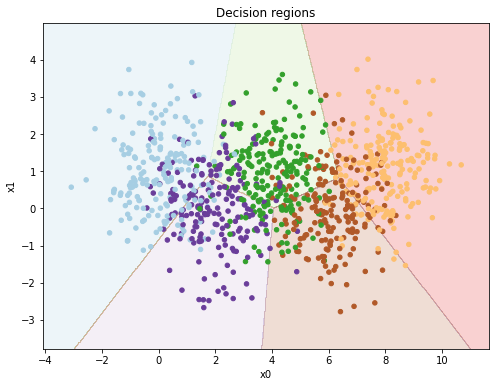

In [1192]:
cl = NumpyMultiLogReg()
cl.fit(X_train, t_train, eta = m_best_eta, epochs = m_best_epochs)
cl.predict(X_val, t_val)
print(cl.accuracy(X_val, t_val))
plot_decision_regions(X_train, t_train, cl)

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. (Don't expect a large difference on a simple task like this.)

Remember that this classifier uses exponetiation followed by softmax in the forward phase. For loss, it uses cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1), where we use mean squared loss together with logistic activation in both the hidden and the last layer.

Since this part is more complex, we will do it in two rounds. In the first round, we will go stepwise through the algorithm with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass through the algorithm at p. 78 in Marsland.

In the second round, we will turn this code into a more general classifier. We can train and test this on (X, t) and (X, t2), but also on other datasets.

## Round 1: One epoch of training

### Scaling
First we have to scale our data. Make a standard scaler (normalizer) and scale the data. Remember, not to follow Marsland on this point. The scaler should be constructed from the training data only, but be applied both to training data and later on to validation and test data.

In [1193]:
class Normalizer():
    
    def fit(self, X_train):
        self.mean = np.mean(X_train)
        self.SD = np.std(X_train)
    
    def transform(self, X):
        return (X - self.mean)/self.SD

### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 3. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user, is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [1194]:
eta = 0.01 #Learning rate
dim_hidden = 3

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. 

The target values have to be converted from simple numbers, *0, 2,..* to "one-hot-encoded" vectors similarly to the multi-class task. After the conversion, we can read *dim_out* off from *t_train*. 

In [1195]:
def enc(t):
    b = np.zeros((t.size, t.max()+1))
    b[np.arange(t.size),t] = 1
    return b

In [1196]:
# convert t_train
Norm = Normalizer()
Norm.fit(X_train)
scaled_X_train = Norm.transform(X_train)
enc_t_train = enc(t_train)

P, dim_in = np.shape(scaled_X_train)
a, dim_out = np.shape(enc_t_train)

print(dim_in, dim_out)

2 5


We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make sure that you take the bias terms into consideration and get the correct dimensions. The weight matrices should be initialized to small random numbers, not to zeros. It is important that they are initialized randomly, both to ensure that different neurons start with different initial values and to generate different results when you rerun the classifier. In this introductory part, we have chosen to fix the random state to make it easier for you to control your calculations. But this should not be part of your final classifier.

In [1197]:
# Your code
def negative_add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([-1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        bias = np.negative(bias)
        return np.concatenate([bias, X], axis  = 1) 

In [1198]:
rng = np.random.RandomState(2022)
weights1 = (rng.rand(dim_in + 1, dim_hidden) * 2 - 1)/np.sqrt(dim_in)
weights2 = (rng.rand(dim_hidden+1, dim_out) * 2 - 1)/np.sqrt(dim_hidden)

In [1199]:
weights1
np.shape(weights1)

(3, 3)

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [1200]:
# Your code
# hidden_activations = 3

def forward(X_train, t_train, weights1, weights2):
    """From input to hidden layer"""
    X_train = negative_add_bias(X_train)
    hidden_output = X_train @ weights1
    print("hidden_activations: ", hidden_output.shape[-1])
    a = logistic(hidden_output)
    
    """From hidden to output"""
    a = negative_add_bias(a)
    output = a @ weights2
    print("output_activations:", output.shape[-1])
    output = logistic(output) 
    return output, a

a, b = forward(scaled_X_train, t_train, weights1, weights2)
print(a)
print("Looking at how the results are, they seem reasonable")
print("The values look alright, since we are supposed to get probabilities because we use logistic-activation function")
print("The format seems also reasonable, since we know dim-out also is 5")
    


hidden_activations:  3
output_activations: 5
[[0.29882145 0.44242648 0.40991151 0.37717324 0.42734361]
 [0.28882368 0.45034517 0.41522382 0.36498874 0.40992805]
 [0.30966821 0.43642565 0.40534359 0.38601408 0.43802738]
 ...
 [0.28605245 0.44016759 0.4102167  0.3838938  0.44826811]
 [0.29247605 0.44184548 0.41015925 0.3796048  0.43614741]
 [0.31367607 0.43996268 0.40706775 0.37861541 0.42105904]]
Looking at how the results are, they seem reasonable
The values look alright, since we are supposed to get probabilities because we use logistic-activation function
The format seems also reasonable, since we know dim-out also is 5


In [1201]:
# Your code
# output_activations =

To control that you are on the right track, you may compare your first output value with our result. We have put the bias term -1 in position 0 in both layers. If you have done anything differently from us, you will not  get the same numbers. But you may still be on the right track!

In [1202]:
print(a[0])
outputs[0, :]


[0.29882145 0.44242648 0.40991151 0.37717324 0.42734361]


NameError: name 'outputs' is not defined

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sum of squared errors. (This amounts to the same as using the mean square error).

In [ ]:
# Your code
#Using the algoritm for MLP in Marsland to compute the errors due to invalid sizes when computing error using MSE in the hidden layer.
def output_loss(t_train, output):
    """Computing the error of output"""
    delta_o = (t_train - output) * output * (1-output)
    return delta_o

delta_o = output_loss(enc_t_train, a)
print(np.shape(delta_o))

(1000, 5)


Calculate the delta terms in the hidden layer.

In [ ]:
# Your code
def hidden_loss(a, weights2, delta_o):
    delta_h = a*(1-a)*(delta_o @ weights2.T)
    return delta_h

delta_h = hidden_loss(b, weights2, delta_o)
print(delta_h.shape)



(1000, 4)


Update the weights in both layers.. See whether the weights have changed.

In [ ]:
print("weights, before update:")
print("weights1", weights1)
print("weights2", weights2)
print("----")

new_weights1 = weights1 - eta*((negative_add_bias(scaled_X_train)).T @ delta_h[:,1:])
new_weights2 = weights2 - eta*(((b).T @ delta_o))
print("updated weights1:", new_weights1)
print("----")
print("updated weights1:",new_weights2)

weights, before update:
weights1 [[-0.6938717  -0.00133246 -0.54675803]
 [-0.63643285  0.26220593 -0.01840165]
 [ 0.56237224  0.20852872  0.56139063]]
weights2 [[ 0.25534462  0.38261397  0.37824303  0.38518453  0.52774934]
 [-0.15236916 -0.00596099 -0.1853185   0.13790511  0.55140373]
 [-0.46599894  0.28198504 -0.23960097 -0.23246968  0.29153125]
 [-0.55579925  0.02740963  0.42081427 -0.12835323 -0.33233223]]
----
updated weights1: [[-0.74636629 -0.00304502 -0.51242906]
 [-0.63021543  0.19470828 -0.163923  ]
 [ 0.55051278  0.21862016  0.57119018]]
----
updated weights1: [[ 4.53845086e-02 -1.88436030e-01 -1.13601642e-01 -4.14443750e-02
  -5.04303860e-02]
 [-1.40570966e-01  2.63391365e-01  1.46290724e-01  3.11667785e-01
   9.06880815e-01]
 [-3.26074907e-01  5.70941865e-01 -3.76938658e-02  9.36497127e-03
   5.66039496e-01]
 [-4.52416716e-01  3.32788182e-01  6.82045159e-01  1.16636257e-01
   8.63785927e-04]]


As an aid, you may compare your new weights with our results. But again, you may have done everything correctly even though you get a different result. For example, there are several ways to introduce the mean squared error. They may give different results after one epoch. But if you run sufficiently many epochs, you will get about the same classifier.

In [ ]:
print("New weights:")
print(weights1)

New weights:
[[-0.64918987  0.0049323  -0.57494453]
 [-0.63388739  0.32480283  0.08132063]
 [ 0.51939233  0.17555818  0.58007288]]


##  Step 2: A Multi-layer neural network classifier
### Make the classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names. And don't fix the random numbers within the classifier.

In [1]:
rng = np.random.RandomState()
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.001, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden
        
    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs."""
        # Initilaization
        # Fill in code for initalization
        #First we scale X_train (using the noramzlier class i made earlier)
        Norm = Normalizer()
        Norm.fit(X_train)
        scaled_X_train = Norm.transform(X_train)
        scaled_X_train = negative_add_bias(scaled_X_train)
        
        enc_t_train  = enc(t_train)
        self.dim_out = np.shape(enc_t_train)[-1]
        self.dim_in  = np.shape(scaled_X_train)[-1]
        
        self.weights1 = (rng.rand(self.dim_in + 1, self.dim_hidden) * 2 - 1)/np.sqrt(self.dim_in)
        self.weights2 = (rng.rand(self.dim_hidden + 1, self.dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        
        updatew1 = np.zeros((np.shape(self.weights1)))
        updatew2 = np.zeros((np.shape(self.weights2)))
        for e in range(epochs):
            # Run one epoch of forward-backward
            self.forward(scaled_X_train)
            #backwards
            delta_o = (enc_t_train - self.h) * self.h * (1 - self.h)
            delta_h = self.a*(1 - self.a) * (delta_o @ self.weights2.T)
            
            #update the weights
            self.weights1 -= self.eta*((negative_add_bias(scaled_X_train)).T @ delta_h[:,1:])
            self.weights2 -= self.eta*(((self.a).T @ delta_o))

    def forward(self, X):
        X = negative_add_bias(X)
        hidden_output = X @ self.weights1
        a = logistic(hidden_output)
        self.a = negative_add_bias(a)
        h = self.a @ self.weights2
        self.h = logistic(h)
        return self.a, self.h

    def accuracy(self,X_test, y_test, **kwargs):
        Norm = Normalizer()
        Norm.fit(X_test)
        X_test = Norm.transform(X_test)
        predicted = self.predict(X_test, **kwargs)
        pred = np.array([np.argmax(i) for i in predicted])
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

    def predict(self, X):
        """Predict the value for the item x"""
        X = negative_add_bias(X)
        hid, out = self.forward(X)
        return out
    



NameError: name 'np' is not defined

### Multi-class
Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Tune the hyperparameters to get the best result:
- number of epochs
- learning rate
- number of hidden nodes.

When you are content with the hyperparameters, you should run the same experiment 10 times, collect the accuracies and report the mean value and standard deviation of the accuracies across the experiments. This is common practise when you apply neural networks as the result may vary slightly between the runs. You may plot the decision boundaries for one of the runs.

Discuss shortly how the results and decsion boundaries compare to the "one-vs-rest" classifier.

In [ ]:

def parameters_experiment_MNN():
    best_acc = 0
    for eta in [0.1, 0.01, 0.001]:
        for dim_hidden in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            for epochs in [10, 100, 1000, 10000]:
                cl = MNNClassifier(eta = eta, dim_hidden= dim_hidden)
                cl.fit(X_train, t_train, epochs = epochs)
                acc = cl.accuracy(X_val, t_val)
                if acc > best_acc:
                    best_eta = eta
                    best_dim = dim_hidden
                    best_epochs = epochs
                    best_acc = acc
    return best_acc, best_eta, best_epochs, best_dim
a, b, c, d =parameters_experiment_MNN()
print(a,b,c,d)


0.274 0.001 10000 8
[]


In [ ]:
def ten_times(best_eta, best_epochs, best_dim):
    accs = []
    for i in range(10):
        cl = MNNClassifier(eta = best_eta, dim_hidden= best_dim)
        cl.fit(X_train, t_train, epochs = best_epochs)
        cl.predict(X_val)
        acc = cl.accuracy(X_val, t_val)
        accs.append(acc)
    #plot_decision_regions(X_train, t_train, cl) #non-scaled, and could not get to work
    mean = np.mean(accs)
    sd = np.std(accs)
    return mean, sd
    
        
ten_times(b, c, d)

(0.19979999999999998, 0.030950928903669437)

In [ ]:
cl = MNNClassifier()
cl.fit(X_train, t_train)
#cl.predict(scaled_X_val)
#cl.predict(scaled_X_val)
print(cl.accuracy(X_val, t_val)



0.204


### Binary class
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train a classifier on (X_train, t2_train) and test it on (X_val, t2_val).
Tune the hyper-parameters for the best result. Run ten times with the best setting and report mean and standard deviation. Plot the decision boundaries.

In [ ]:
def binary_parameters_experiment_MNN():
    best_acc = 0
    for eta in [0.1, 0.01, 0.001]:
        for dim_hidden in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            for epochs in [10, 100, 1000, 10000]:
                cl = MNNClassifier(eta = eta, dim_hidden= dim_hidden)
                cl.fit(X_train, t2_train, epochs = epochs)
                acc = cl.accuracy(X_val, t2_val)
                if acc > best_acc:
                    best_eta = eta
                    best_dim = dim_hidden
                    best_epochs = epochs
                    best_acc = acc
    return best_acc, best_eta, best_epochs, best_dim
a, b, c, d = binary_parameters_experiment_MNN()
print(a,b,c,d)

0.572 0.1 100 1


In [ ]:
def binary_ten_times(best_eta, best_epochs, best_dim):
    accs = []
    for i in range(10):
        cl = MNNClassifier(eta = best_eta, dim_hidden= best_dim)
        cl.fit(X_train, t2_train, epochs = best_epochs)
        cl.predict(X_val)
        acc = cl.accuracy(X_val, t2_val)
        accs.append(acc)
    #plot_decision_regions(X_train, t_train, cl) #non-scaled, and could not get to work
    mean = np.mean(accs)
    sd = np.std(accs)
    return mean, sd

binary_ten_times(b, c, d)


(0.42800000000000005, 5.551115123125783e-17)

## For in4050-students: Early stopping
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and store them.

Train a classifier for many epochs. Plot the losses for both the training set and the validation set in the same figure and see whether you get the same effect as in figure 4.11 in Marsland.

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

Run the classifier with various values for *t* and report the accuracy and the numberof epochs ran.

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and evaluate on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the result between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is so the case? 

Also report precision and recall for class 1.

## Multi-class task (X, t)
For IN3050 students compare the one-vs-rest classifier to the multi-layer preceptron. Evaluate on test, validation and training set as above. In4050-students should also include results from the multi-nomial logistic regression.

Comment on the results.

In [ ]:
#Binary task (X, t2)
#linear regression
lin_r_cl = NumpyLinRegClass()
log_r_cl = NumpyLogReg()
MNN_cl = MNNClassifier(eta = b, dim_hidden = d)

log_r_cl.fit(X_train, t2_train, eta = log_r_best_eta, epochs = log_r_best_epochs)
lin_r_cl.fit(X_train, t2_train, eta = lin_r_best_eta, epochs = lin_r_best_epochs)
MNN_cl.fit(X_train, t2_train, epochs = c)
table = [[lin_r_cl.accuracy(X_train, t2_train), lin_r_cl.accuracy(X_val, t2_val), lin_r_cl.accuracy(X_test, t2_test)],
         [log_r_cl.accuracy(X_train, t2_train), log_r_cl.accuracy(X_val, t2_val), log_r_cl.accuracy(X_test, t2_test)],
         [MNN_cl.accuracy(X_train, t2_train), MNN_cl.accuracy(X_val, t2_val), MNN_cl.accuracy(X_test, t2_test)]]
print("linear regression")
print([i for i in table[0]])
print("logistic regression")
print([i for i in table[1]])
print("MNN")
print([i for i in table[2]])

linear regression
[0.707, 0.668, 0.726]
logistic regression
[0.706, 0.672, 0.726]
MNN
[0.386, 0.428, 0.4]


We can see that for the binary case, the accuracies all seem relativeley good, and to the contrary to what the task says, the accuracy is better on the test-set than for the training-, and validation-set for both linear- and logsitic regression.
However, we can see that for MNN, it performs poorly, i believe this is due to a bad implmenetation of the accuracy-method. 


In [ ]:
#Multi-class
multi_cl = NumpyMultiLogReg()
MLP_cl = MNNClassifier(eta = b, dim_hidden = d)
multi_cl.fit(X_train, t_train, eta = m_best_eta, epochs = m_best_epochs)
MLP_cl.fit(X_train, t_train, epochs = c)

table = [[MLP_cl.accuracy(X_train, t_train), MLP_cl.accuracy(X_val, t_val), MLP_cl.accuracy(X_test, t_test)],
         [multi_cl.accuracy(X_train, t_train), multi_cl.accuracy(X_val, t_val), multi_cl.accuracy(X_test, t_test)]]

print("Multi-layer perceptrion")
print(table[0])
print("one vs. rest")
print(table[1]) 

Multi-layer perceptrion
[0.193, 0.204, 0.21]
one vs. rest
[0.747, 0.76, 0.778]


Again, the MLP has bad accuracy, either due to wrong paramters or bad implmenetation of the accuracy-method. However, we do get good results 
for the one vs. rest method. Again, the test-set has better accuracy for 1.v.r, on the other hand we see that for accuracy for the test-set in MLP is a middleground compared to the training-set and the validation-set, which is a good ratio.